In [1]:
%load_ext autoreload

In [2]:
%autoreload
from mine.models.mine import Mine
import torch.nn as nn
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
# import pickle

Device: cuda


In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 1024


# USE 100K TEST DATA
dataset = torchvision.datasets.ImageFolder(
    root='/scratch/network/ls1546/imagenet/ILSVRC/Data/CLS-LOC/test', 
    transform=transform
)

# load part of dataset
indices = torch.arange(20000)
dataset_half = torch.utils.data.Subset(dataset, indices)
dataloader = torch.utils.data.DataLoader(dataset_half, batch_size=batch_size, shuffle=True, num_workers=2)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

cuda:1


In [4]:
image_dim = 224*224*3
# pass images through toy_network to get weights

class Toynetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(image_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

In [5]:
toy_net = Toynetwork().to(device)

In [6]:
toy_net.fc1.weight.size()

torch.Size([1, 150528])

In [7]:
# inputs_list = []
# outputs_list = []
# for inputs, _ in tqdm(dataloader):
#     inputs = torch.flatten(inputs, start_dim=1)
#     inputs = inputs.to(device)

#     with torch.no_grad():
#         outputs_list.append(toy_net(inputs).detach().cpu().numpy())
#         inputs = inputs.detach().cpu().numpy()
#         inputs_list.append(inputs)

#     del inputs

In [8]:
# add hooks, run model with inputs to get activations

# a dict to store the activations
activation = {}
def get_activation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach().cpu().numpy()
        # activation[name] = output.numpy()
    return hook

hook = toy_net.fc1.register_forward_hook(get_activation('fc1'))

In [9]:
inputs_list = []
act_list = []

for inputs, _ in tqdm(dataloader):
    inputs = torch.flatten(inputs, start_dim=1)
    inputs = inputs.to(device)

    with torch.no_grad():
        output = toy_net(inputs)
        
        # collect the activations
        act_list.append(activation['fc1'])

        inputs = inputs.detach().cpu().numpy()
        inputs_list.append(inputs)

    del inputs

# detach the hooks
hook.remove()

100%|█████████████████████████████████████████| 20/20 [00:42<00:00,  2.11s/it]


In [10]:
toy_net.fc1.weight

Parameter containing:
tensor([[-2.3882e-03,  9.0667e-04, -2.3533e-03,  ...,  1.0872e-03,
          1.3690e-03,  9.9376e-05]], device='cuda:1', requires_grad=True)

In [11]:
# send X=input images, Y=neuron responses to inputs (can we use the outputs here? or do we need hooks again?) into MINE, T's weights
# at 1st layer should approximate the random weights in toy_net

In [12]:
act_length = (len(act_list) - 1)*batch_size + len(act_list[len(act_list)-1])
act_length, len(act_list), act_list[0].shape

(20000, 20, (1024, 1))

In [13]:
samples = (len(inputs_list) - 1)*batch_size + len(inputs_list[len(inputs_list)-1])
images_flat = np.zeros((samples, 224*224*3))
responses = np.zeros((act_length, 1))
x_dim=224*224*3
y_dim=1

for batch in range(len(act_list)):
    for image in range(len(act_list[batch])):
        responses[batch*len(act_list[0])+image, 0] = act_list[batch][image, 0]
        images_flat[batch*len(act_list[0])+image, :] = inputs_list[batch][image].flatten()

In [14]:
del act_list, inputs_list

In [15]:
images_flat[-1]

array([ 1.95778739,  1.87216365,  1.9064132 , ..., -0.91555554,
       -0.7586928 , -0.84583873])

In [16]:
image_network = nn.Sequential(
    nn.Linear(x_dim + y_dim, 1),
    nn.ReLU(),
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

# image_network = torch.compile(image_network)

mine = Mine(
    T = image_network,
    loss = 'mine', #mine_biased, fdiv
    method = 'concat'
)

mi, loss_log = mine.optimize(images_flat, responses, 50, batch_size)

  0%|          | 0/50 [00:00<?, ?it/s]

Final MI: -5.8025121688842773e-05


In [22]:
mine.T[1].weight.shape, toy_net.fc1.weight.shape

(torch.Size([1, 150529]), torch.Size([1, 150528]))

In [18]:
torch.save(mine.T, 'mineTtoy.pth')
np.save('mitoy.npy', mi)
np.save('loss_logtoy.npy', torch.stack(loss_log).detach().numpy())
np.save('images_flattoy.npy', images_flat)
np.save('responsestoy.npy', responses)

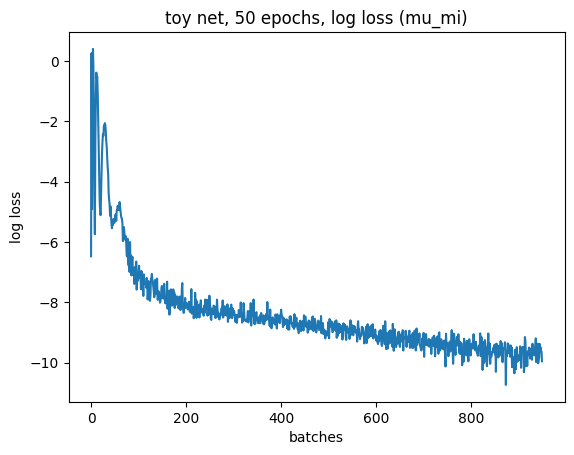

In [19]:
plt.figure()
plt.plot(np.log(torch.stack(loss_log).detach().numpy()))
plt.title("toy net, 50 epochs, log loss (mu_mi)")
plt.ylabel("log loss")
plt.xlabel("batches")
plt.show()

In [25]:
trained, real = mine.T[1].weight.detach().cpu().numpy(), toy_net.fc1.weight.detach().cpu().numpy()

In [34]:
x=np.arange(150528)
real[0,:].shape

(150528,)

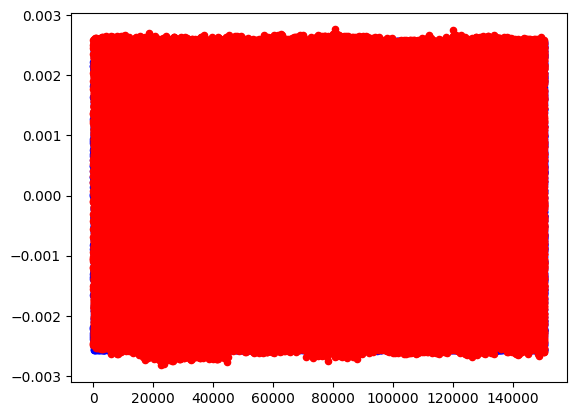

In [40]:
plt.figure()
plt.scatter(np.arange(150528), real[0,:], s=20, c='b')
plt.scatter(np.arange(150528), trained[0,:-1], s=20, c='r')
plt.show()